# H&M Personalization Recommendation
## Item-Based Recommendation

## Data Preprocessing

In [982]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cosine
from scipy.spatial.distance import correlation
import time
import itertools
import matplotlib.pyplot as plt

In [5]:
transaction_data = pd.read_csv('transactions_train.csv')

In [6]:
transaction_data

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2
...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,929511001,0.059305,2
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,891322004,0.042356,2
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,918325001,0.043203,1
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,833459002,0.006763,1


In [27]:
articles_df = pd.read_csv('articles.csv')
articles_df

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105537,953450001,953450,5pk regular Placement1,302,Socks,Socks & Tights,1010014,Placement print,9,Black,...,Socks Bin,F,Menswear,3,Menswear,26,Men Underwear,1021,Socks and Tights,Socks in a fine-knit cotton blend with a small...
105538,953763001,953763,SPORT Malaga tank,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey,A,Ladieswear,1,Ladieswear,2,H&M+,1005,Jersey Fancy,Loose-fitting sports vest top in ribbed fast-d...
105539,956217002,956217,Cartwheel dress,265,Dress,Garment Full body,1010016,Solid,9,Black,...,Jersey,A,Ladieswear,1,Ladieswear,18,Womens Trend,1005,Jersey Fancy,"Short, A-line dress in jersey with a round nec..."
105540,957375001,957375,CLAIRE HAIR CLAW,72,Hair clip,Accessories,1010016,Solid,9,Black,...,Small Accessories,D,Divided,2,Divided,52,Divided Accessories,1019,Accessories,Large plastic hair claw.


### Retrieving Utility Matrix 
- Built with articles.csv and transactions_train.csv

In [56]:
df_purchase = pd.read_csv('utility_with_product_type.csv')

In [57]:
df_purchase

,customer_id,Accessories set,Alice band,Baby Bib,Backpack,Bag,Ballerinas,Beanie,Belt,Bikini top,...,Vest top,Wallet,Washing bag,Watch,Waterbottle,Wedge,Weekend/Gym bag,Wireless earphone case,Wood balls,Zipper head
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0,0,0,0,1,0,0,0,17,...,8,0,0,0,0,0,0,0,0,0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1362276,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0,0,0,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,0
1362277,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0,0,0,0,0,0,0,0,4,...,5,0,0,0,0,0,0,0,0,0
1362278,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1362279,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Separating User_ID's from df_purchase

In [58]:
metadata = df_purchase['customer_id']
metadata

0          00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...
1          0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
2          000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
3          00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...
4          00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...
                                 ...                        
1362276    ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...
1362277    ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...
1362278    ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...
1362279    ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...
1362280    ffffd9ac14e89946416d80e791d064701994755c3ab686...
Name: customer_id, Length: 1362281, dtype: object

In [59]:
df_purchase.drop('customer_id', axis=1, inplace=True)

In [60]:
df_purchase

,Accessories set,Alice band,Baby Bib,Backpack,Bag,Ballerinas,Beanie,Belt,Bikini top,Blanket,...,Vest top,Wallet,Washing bag,Watch,Waterbottle,Wedge,Weekend/Gym bag,Wireless earphone case,Wood balls,Zipper head
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,17,0,...,8,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1362276,0,0,0,0,0,0,0,0,8,0,...,0,0,0,0,0,0,0,0,0,0
1362277,0,0,0,0,0,0,0,0,4,0,...,5,0,0,0,0,0,0,0,0,0
1362278,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1362279,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Normalizing utility matrix
- Using Min-Max Normalization

In [70]:
#normalize the columns
df_norm = (df_purchase - df_purchase.min()) / (df_purchase.max() - df_purchase.min())

df_norm

,Accessories set,Alice band,Baby Bib,Backpack,Bag,Ballerinas,Beanie,Belt,Bikini top,Blanket,...,Vest top,Wallet,Washing bag,Watch,Waterbottle,Wedge,Weekend/Gym bag,Wireless earphone case,Wood balls,Zipper head
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.008547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.012987,0.0,0.0,0.0,0.150442,0.0,...,0.068376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.008850,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.008850,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1362276,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.070796,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1362277,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.035398,0.0,...,0.042735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1362278,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.008547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1362279,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Performing Item-Based KNN

### Testing dataset
- For testing with smaller chunk of original dataset
- To lower processing time while building model

In [733]:
test_df = df_norm[:1000000]
test_df

,Accessories set,Alice band,Baby Bib,Backpack,Bag,Ballerinas,Beanie,Belt,Bikini top,Blanket,...,Vest top,Wallet,Washing bag,Watch,Waterbottle,Wedge,Weekend/Gym bag,Wireless earphone case,Wood balls,Zipper head
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.008547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.012987,0.0,0.0,0.0,0.150442,0.0,...,0.068376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.008850,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.008850,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999996,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999997,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999998,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Building Model using Multiple Helper Functions
- main()
- create_target()
- compute_item_similarity()
- find_k_most_similar_items()
- evaluate_recommendations()

#### Returns:
- recommendations (target_user, target_item, k_most_similar_items)
- average_accuracy
- k-value

In [962]:
def main(dataframe, k, num_targets):
    
    # Build empty recommendations & accuracy_lst lists
    recommendations = []
    accuracy_lst = []
    
    # for loop to retrieve accuracies of all target users
    # Users several helper functions, including: create_target(), find_k_most_similar_items(), evaluate_recommendations()
    for i in range(num_targets):
        
        # Selects target_user and target_items
        # Also returns the purchased_items (nonzero_items) for the target_user for later evaluation
        target_user, target_item, nonzero_items = create_target(dataframe)
        
        # compute the item-item similarity matrix
        #returns the dataframe
        item_similarities = compute_item_similarity(dataframe)
        
        # Finds k most similar items to the target_item based on Cosine Sim
        # returns these items and the k_value used
        k_most_similar_items, k = find_k_most_similar_items(item_similarities, target_item, k)
        
        # appends target_user, target_item, k_most_similar_items to recommendations list
        recommendations.append((target_user, target_item, k_most_similar_items))
        
        # evaluates the accuracy of each recommended item
        # returns accuracy
        accuracy = evaluate_recommendations(k_most_similar_items, nonzero_items)
        
        # appends the accuracy to the accuracy_lst list
        accuracy_lst.append(accuracy)
       
    # Computes the average accuracy of recommendations for all targets
    average_accuracy = sum(accuracy_lst)/len(accuracy_lst)
    
    # returns recommendations, average_accuracy, k
    return recommendations, average_accuracy, k


def create_target(dataframe):
    
    # create the target user, target item, and nonzero_items (purchased items)
    # Makes sure that the target user has purchased at least 2 items
    while True:
        # randomly sample a target_user
        target_user = dataframe.sample().index[0]
        
        # writes all items of target_user to list
        purchased_items = dataframe.loc[target_user].index.tolist()

        # create an empty list to store items with non-zero values (aka purchased items)
        nonzero_items = []
        for item in purchased_items:
            if dataframe.loc[target_user, item] > 0:
                nonzero_items.append(item)

        # if there are at least two nonzero items, randomly select one as the target item
        if len(nonzero_items) >= 2:
            target_item = np.random.choice(nonzero_items)
            break

    return target_user, [target_item], nonzero_items

def compute_item_similarity(dataframe):
    
    # multiply matrix times its inverse
    item_similarities = dataframe.T.dot(dataframe)
    
    # ensuring column names are strings
    item_similarities.columns = [str(col) for col in item_similarities.columns] 
    
    # replacing NA values with zeros
    item_similarities.fillna(0, inplace=True)
    
    return item_similarities

def find_k_most_similar_items(item_similarities, target_item, k):
    
    # Retrieve the metric parameters/feature names
    metric_params = {'feature_names': item_similarities.columns}
    
    # build Nearest Neighbors model from sklearn
    # Using Cosine similarity and the 'brute' algorithm
    model = NearestNeighbors(n_neighbors=k+1, algorithm='brute', metric='cosine')
    
    # Fit the model but frop NA values
    model.fit(item_similarities.dropna(axis=1))
    
    # Create empty list for the most similar items
    k_most_similar_items = []
    
    # loop through target item and return k most similar items
    for item in target_item:
        if item in item_similarities.index:
            target_item_index = item_similarities.index.get_loc(str(item))
            distances, indices = model.kneighbors(item_similarities.iloc[target_item_index, :].values.reshape(1, -1))
            k_most_similar_items.append([item_similarities.index[i] for i in indices[0] if item_similarities.index[i] != item])
    k_most_similar_items = list(itertools.chain(*k_most_similar_items))
    return k_most_similar_items, k

def evaluate_recommendations(k_most_similar_items, nonzero_items):
    
    # set the number of correctly recommended items based on users purchases to zero
    num_correct = 0
    
    # loop through k_most_similar_items
    # Check if item in nonzero_items (purchased items) of target_user
    for item in k_most_similar_items:
        if item in nonzero_items:
            
                # If recommended item in purchased item add 1 to num_correct
                num_correct += 1
        
        # accuracy is calculated by subtracting the num_correct recommended items by length of k_most_similar_items 
        accuracy = num_correct/len(k_most_similar_items)
    
    return accuracy

## Evaluating Models
- Model 1: k=1 & num_targets = 1000
- Model 2: k=2 & num_targets = 1000

#### Run Item Based Collabrotive Filtering Model 1
- Dataframe = Normalized User-Item Transaction Dataframe
- Number of Neighbors (k) = 1
- Number of Targets (num_targets) = 1000

In [971]:
print(f'The accuracy of this model is: {average_accuracy}')

for target_user, target_item, k_most_similar_items in recommendations:
    print(f'User {target_user} bought {target_item} on the H&M webshop.')
    print(f'The {k} items that should be recommended to this user are: {k_most_similar_items}\n')

The accuracy of this model is: 0.433
User 983073 bought ['Bra'] on the H&M webshop.
The 1 items that should be recommended to this user are: ['Underwear bottom']

User 742083 bought ['Blouse'] on the H&M webshop.
The 1 items that should be recommended to this user are: ['Shirt']

User 1106779 bought ['Trousers'] on the H&M webshop.
The 1 items that should be recommended to this user are: ['Shirt']

User 218091 bought ['Blazer'] on the H&M webshop.
The 1 items that should be recommended to this user are: ['Shirt']

User 264097 bought ['Night gown'] on the H&M webshop.
The 1 items that should be recommended to this user are: ['Robe']

User 817143 bought ['Swimwear bottom'] on the H&M webshop.
The 1 items that should be recommended to this user are: ['Bikini top']

User 1327566 bought ['Bootie'] on the H&M webshop.
The 1 items that should be recommended to this user are: ['Garment Set']

User 524283 bought ['Jacket'] on the H&M webshop.
The 1 items that should be recommended to this user 

#### Run Item Based Collabrotive Filtering Model
- Dataframe = Normalized User-Item Transaction Dataframe
- Number of Neighbors (k) = 2
- Number of Targets (num_targets) = 1000

In [967]:
recommendations, average_accuracy, k = main(df_norm, 2, 1000)

/Users/luukwassenaar/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  "X does not have valid feature names, but"
/Users/luukwassenaar/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  "X does not have valid feature names, but"
/Users/luukwassenaar/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  "X does not have valid feature names, but"
/Users/luukwassenaar/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  "X does not have valid feature names, but"
/Users/luukwassenaar/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:4

In [969]:
print(f'The accuracy of this model is: {average_accuracy}')

for target_user, target_item, k_most_similar_items in recommendations:
    print(f'User {target_user} bought {target_item} on the H&M webshop.')
    print(f'The {k} items that should be recommended to this user are: {k_most_similar_items}\n')
    


The accuracy of this model is: 0.369
User 478024 bought ['T-shirt'] on the H&M webshop.
The 2 items that should be recommended to this user are: ['Top', 'Sweater']

User 56839 bought ['Sneakers'] on the H&M webshop.
The 2 items that should be recommended to this user are: ['Ballerinas', 'Sandals']

User 199996 bought ['Unknown'] on the H&M webshop.
The 2 items that should be recommended to this user are: ['Bra', 'T-shirt']

User 332067 bought ['Underwear bottom'] on the H&M webshop.
The 2 items that should be recommended to this user are: ['Bra', 'Robe']

User 1103327 bought ['Earring'] on the H&M webshop.
The 2 items that should be recommended to this user are: ['Sunglasses', 'Ring']

User 123445 bought ['Dress'] on the H&M webshop.
The 2 items that should be recommended to this user are: ['Blouse', 'Shirt']

User 740880 bought ['Sweater'] on the H&M webshop.
The 2 items that should be recommended to this user are: ['T-shirt', 'Shirt']

User 229813 bought ['Skirt'] on the H&M webshop.

### Retrieving Model Accuracies for 10 Different Models
- k-values: 1 through 10
- number of target users: 100

#### Returns Table with k-values as rows, and accuracy as column

In [977]:
def evaluation_table(recommendations, average_accuracy, k):
    model_accuracies = {}

    for i in range(10):
        recommendations, average_accuracy, k = main(df_norm, i+1, 100)
        model_accuracies[i+1] = average_accuracy
        
    df_model_accuracies = pd.DataFrame.from_dict(model_accuracies, orient='index', columns=['Accuracy'])
    
    return df_model_accuracies

In [978]:
df_model_accuracies = evaluation_table(recommendations, average_accuracy, k)
df_model_accuracies

/Users/luukwassenaar/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  "X does not have valid feature names, but"
/Users/luukwassenaar/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  "X does not have valid feature names, but"
/Users/luukwassenaar/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  "X does not have valid feature names, but"
/Users/luukwassenaar/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  "X does not have valid feature names, but"
/Users/luukwassenaar/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:4

,Accuracy
1,0.360000
2,0.375000
3,0.386667
4,0.357500
5,0.364000
6,0.340000
7,0.344286
8,0.325000
9,0.306667
10,0.317000


In [979]:
df_model_accuracies

,Accuracy
1,0.360000
2,0.375000
3,0.386667
4,0.357500
5,0.364000
6,0.340000
7,0.344286
8,0.325000
9,0.306667
10,0.317000


### Graphing Model Accuracies
- k-values: 1 through 10
- number of target users: 100

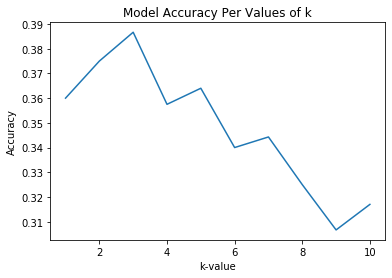

In [985]:
plt.plot(df_model_accuracies.index, df_model_accuracies['Accuracy'])
plt.xlabel('k-value')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Per Values of k')
plt.show()